In [214]:
# import librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
import ipywidgets as widgets
from IPython.display import display
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('en_core_web_lg')

In [107]:
tweets = pd.read_csv(r"C:\Users\HP\Documents\projects\Sentiment Analysis\2024-08-11 4_06pm.csv")
data = tweets.copy()

In [108]:
data.head()

,TWEET_ID,USER_ID,CREATED_AT,TEXT,URL,MENTIONS,LANG,FAVOURITES,RETWEETS,REPLIES,QUOTES,VIEW_COUNT,HASHTAGS
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN


In [109]:
data.shape

(1332, 13)

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TWEET_ID    1332 non-null   int64  
 1   USER_ID     1332 non-null   int64  
 2   CREATED_AT  1332 non-null   object 
 3   TEXT        1332 non-null   object 
 4   URL         578 non-null    object 
 5   MENTIONS    206 non-null    object 
 6   LANG        1332 non-null   object 
 7   FAVOURITES  1332 non-null   int64  
 8   RETWEETS    1332 non-null   int64  
 9   REPLIES     1332 non-null   int64  
 10  QUOTES      1332 non-null   int64  
 11  VIEW_COUNT  782 non-null    float64
 12  HASHTAGS    157 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 135.4+ KB


### **DATA CLEANING AND PREPROCESSING**
The columns with missing values will not be used within the scope of this notebook. In that case, we would not be handling the missing values

In [111]:
data.columns = data.columns.str.strip().str.lower()
data.columns

Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count',
       'hashtags'],
      dtype='object')

A `wordcount` column is created, and wordcounts < 2 will be dropped

In [112]:
data['wordcount'] = data.text.apply(lambda x: len(x.split(' ')))
data = data[data['wordcount'] >= 2].reset_index(drop=True)

In [113]:
print('Dataset shape:', data.shape)
print(data.columns)

Dataset shape: (1319, 14)
Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count', 'hashtags',
       'wordcount'],
      dtype='object')


In [171]:
def preprocess(text):
    """
    Preprocesses the input text by removing special characters, stopwords and changes the characters  to lower case.
    
    Parameters:
    text (str): The raw tweet text.

    Returns:
    str: The cleaned, preprocessed text without punctuation nor stopwords.
    """
    lemmatizer = WordNetLemmatizer()
    preprocessed_text = []
    doc = nlp(text) 
    for i in doc:
        if i.is_punct:
            continue
        i = i.lemma_.lower()
        if i in stopwords.words('english'):
            continue
        preprocessed_text.append(i.lower())
        
    return ' '.join(preprocessed_text)


In [172]:
data['processed_text'] = data['text'].apply(preprocess)

In [173]:
data.head()

,tweet_id,user_id,created_at,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,wordcount,processed_text,sentiment_score,sentiments
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN,11,piggyvest life saver introduce friend,0.4939,positive
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN,8,piggyvest go think say die,-0.5994,negative
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN,3,use piggyvest bro,0.0000,neutral
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN,7,piggyvest need stop withdraw,-0.2960,negative
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN,52,female friend send screenshot saving jollof ...,0.6705,positive


### **SENTIMENT ANALYSIS**
We will use a NLTK's inbuilt SentimentAnalyzer model to classify the sentiment of each tweet. The model is fine-tuned for sentiment analysis and will return an array of probabilities representing `negative`, `neutral`, `positive` and `compound`. The scores returned by VADER `compound` range from -1 to 1, -1 being very negative and one being very positive.

#### Sentiment on `processed_text` without stopwords

In [174]:
sentiment = SentimentIntensityAnalyzer()

data['sentiment_score'] = data.processed_text.apply(lambda x: sentiment.polarity_scores(x)['compound'])

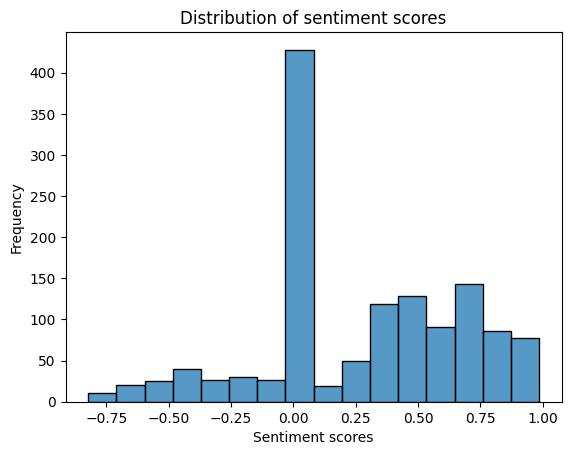

In [175]:
sns.histplot(data['sentiment_score'])
plt.title('Distribution of sentiment scores')
plt.ylabel('Frequency')
plt.xlabel('Sentiment scores')
plt.show()

In [176]:
data['sentiment_score'].describe()

count    1319.000000
mean        0.263923
std         0.403362
min        -0.822500
25%         0.000000
50%         0.278200
75%         0.624900
max         0.985500
Name: sentiment_score, dtype: float64

(Pawan, 2020) in his work [https://www.kaggle.com/pawanbhandarkar/training-a-sith-lord] compared different split points for the data to identify the best way to split the output of Vader into Negative, Positive and Neutral Categories. This was performed on the US Airline Twitter Dataset but it is expected to be similarly applicable to other Twitter datasets as well.

Best Thresholds for splitting Vader tweet sentiments:

> sentiment['compound'] < -0.05 => Negative
>
> sentiment['compound'] > 0.35 => Positive
>
> -0.05 Neutral < sentiment['compound'] < 0.35 => Neutral

In [177]:
def sentiment_analyzer(compound_score):
    """
    Classify sentiment based on a compound score.

    Parameters
    ----------
    compound_score : float
        The compound sentiment score to classify.

    Returns
    -------
    str
        The sentiment label.
    """

    if compound_score >= 0.35:
        return 'positive'
    
    elif compound_score <= -0.05:
        return 'negative'
    
    else:
        return 'neutral'


In [178]:
data['sentiments'] = data['sentiment_score'].apply(sentiment_analyzer)
data['sentiments'].value_counts()

positive    604
neutral     538
negative    177
Name: sentiments, dtype: int64

In [195]:
positive = data[data['sentiments'] == 'positive']
negative = data[data['sentiments'] == 'negative']
neutral = data[data['sentiments'] == 'neutral']

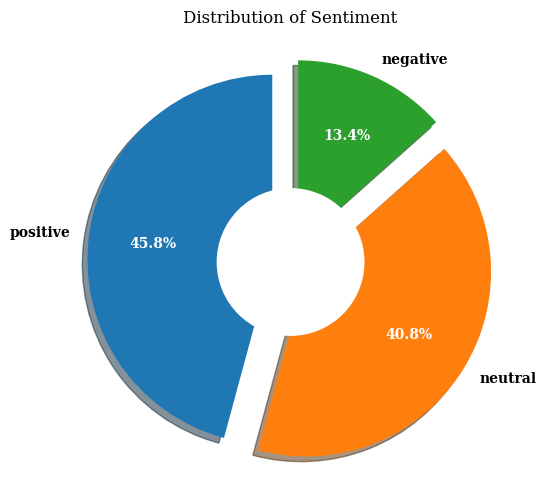

In [179]:
label_data = data['sentiments'].value_counts()
explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribution of Sentiment')
plt.show()

In [180]:
data.head()

,tweet_id,user_id,created_at,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,wordcount,processed_text,sentiment_score,sentiments
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN,11,piggyvest life saver introduce friend,0.4939,positive
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN,8,piggyvest go think say die,-0.5994,negative
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN,3,use piggyvest bro,0.0000,neutral
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN,7,piggyvest need stop withdraw,-0.2960,negative
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN,52,female friend send screenshot saving jollof ...,0.6705,positive


### **EXPLORATORY DATA ANALYSIS**

#### Analyzing the frequency of specific keywords

In [213]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [209]:
def most_common_chart(dataframe, title):
	corpus = ' '.join([i for i in dataframe.processed_text.values])
	tokenized_word = word_tokenize(corpus)
	count = FreqDist(tokenized_word)
	most_common = count.most_common(10)

	plt.figure(figsize=(10, 6))
	ax = sns.barplot(x=[word[1] for word in most_common], y=[word[0] for word in most_common])
	ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
	plt.xlabel('Frequency')
	plt.ylabel('Word')
	plt.title(title)
	print(most_common)
	plt.show()

[('piggyvest', 1265), ('money', 213), ('save', 204), ('use', 156), ('saving', 134), ('get', 131), ('go', 122), ('like', 105), ('dey', 90), ('see', 88)]


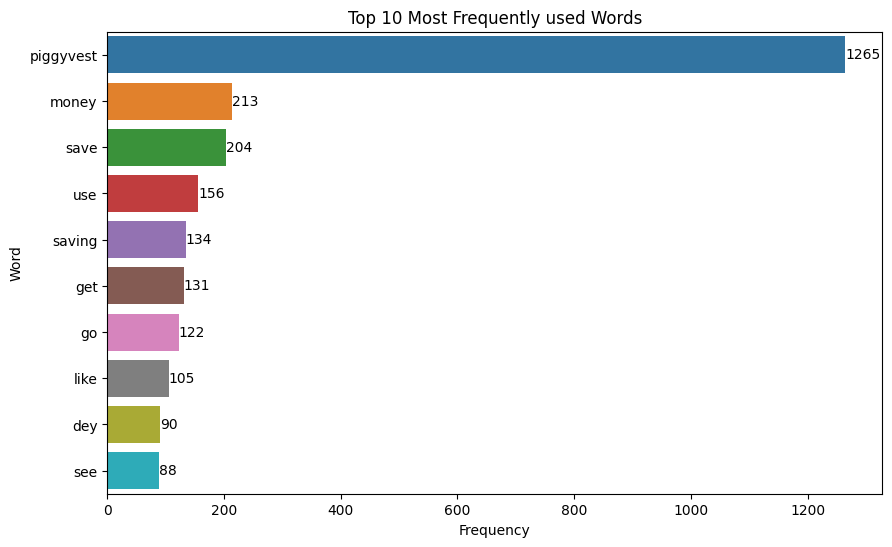

In [210]:
most_common_chart(data, 'Top 10 Most Frequently used Words')

[('piggyvest', 590), ('save', 195), ('money', 108), ('use', 104), ('like', 95), ('saving', 94), ('get', 86), ('start', 73), ('interest', 62), ('amp', 62)]


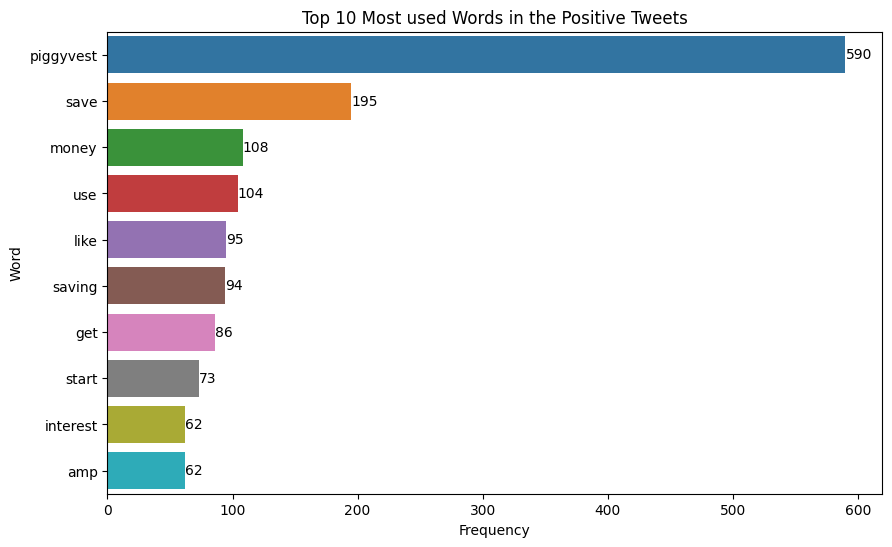

In [211]:
most_common_chart(positive, 'Top 10 Most used Words in the Positive Tweets')

[('piggyvest', 169), ('money', 32), ('go', 31), ('mr', 20), ('ibu', 19), ('broke', 17), ('sportybet', 17), ('asisat', 14), ('oshoala', 14), ('use', 13)]


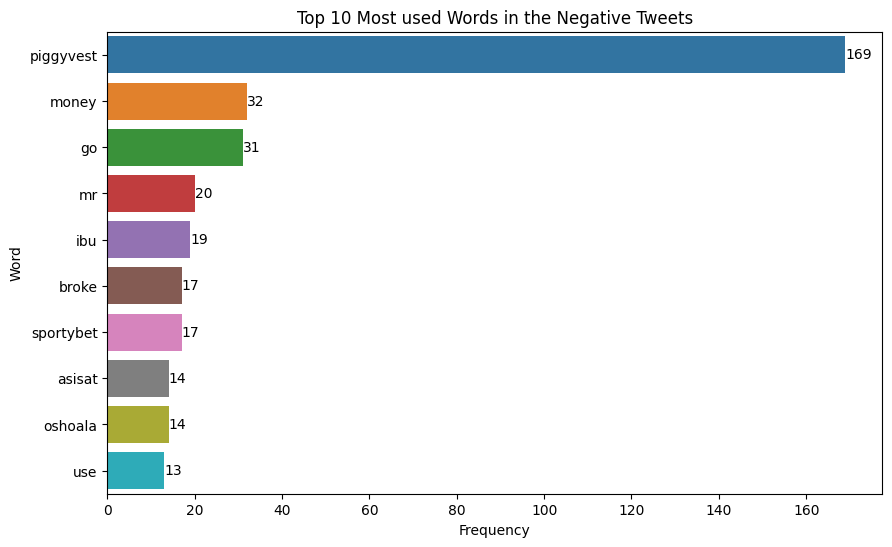

In [212]:
most_common_chart(negative, 'Top 10 Most used Words in the Negative Tweets')

#### Topic Modeling
Implementing the topic modeling technique, **Latent Dirichlet Allocation (LDA)** to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [193]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(data['processed_text'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
piggyvest dey na account save money piggyvest dey wey person piggyvest account

Topic 1:
piggyvest cowrywise money open bank piggyvest cowrywise open piggyvest cowrywise piggyvest year saving

Topic 2:
piggyvest day today user break buy ask saving 000 add

Topic 3:
piggyvest save money like app year know use account withdraw

Topic 4:
piggyvest use use piggyvest link save start 000 amp saving invest

Topic 5:
piggyvest opay zenith tinubu lagos kuda believe naira abuja send

Topic 6:
piggyvest today make davido love good way toyin abraham abraham toyin

Topic 7:
mr mr ibu ibu piggyvest happie sportybet boys larry happie boys broke

Topic 8:
piggyvest saving dollar cofounder people say think rate naira thank

Topic 9:
piggyvest money use piggyv save send join lock month end



In [218]:
data.head()

,tweet_id,user_id,created_at,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,wordcount,processed_text,sentiment_score,sentiments
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN,11,piggyvest life saver introduce friend,0.4939,positive
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN,8,piggyvest go think say die,-0.5994,negative
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN,3,use piggyvest bro,0.0000,neutral
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN,7,piggyvest need stop withdraw,-0.2960,negative
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN,52,female friend send screenshot saving jollof ...,0.6705,positive


<AxesSubplot:xlabel='sentiments', ylabel='wordcount'>

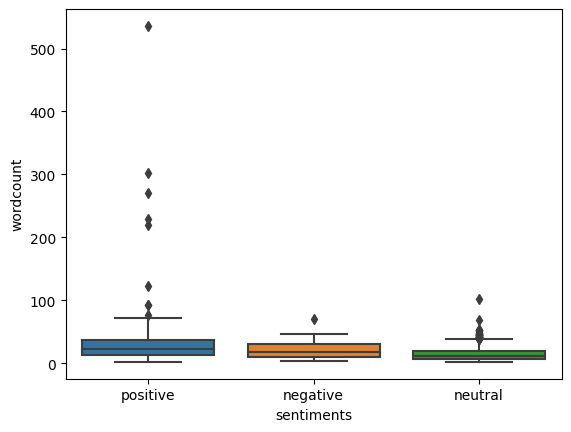

In [224]:
sns.boxplot(data=data, y='wordcount', x='sentiments')

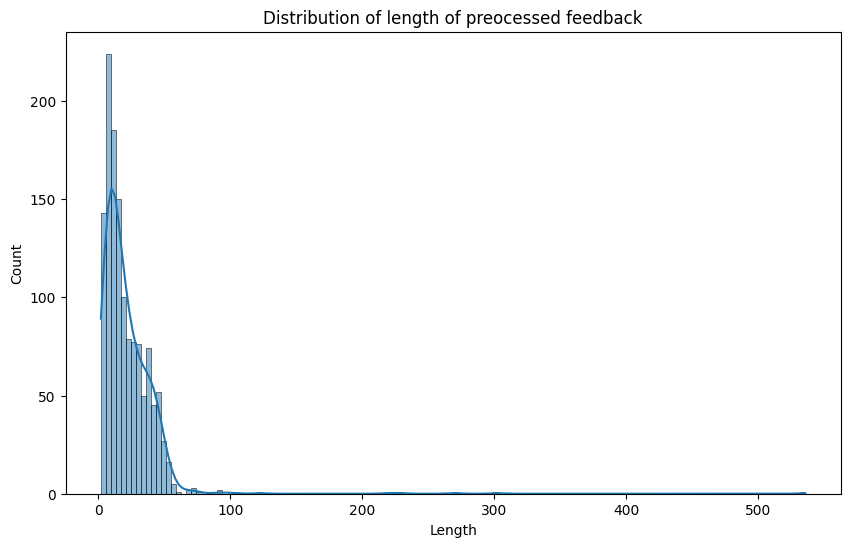

In [226]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(data['wordcount'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [215]:
data.columns

Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count', 'hashtags',
       'wordcount', 'processed_text', 'sentiment_score', 'sentiments'],
      dtype='object')